In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Random variables and simulation

If you are working in computational modelling its highly likely that you will need to make use of the `numpy.random` namespace.  This provides a variety of distributions that you can use for efficient sampling.  Let's take a look at a few example distributions. For example generating 100,000 samples from the uniform, exponential distributions and normal distributions:

In [2]:
def distribution_plot(samples, bins=100):
    '''
    helper function to visualise the distributions
    '''
    hist = np.histogram(samples, bins=np.arange(bins), 
                        density=True)
    plt.plot(hist[0]);
    plt.ylabel('p(x)');
    plt.xlabel('x');

## Uniform distribution

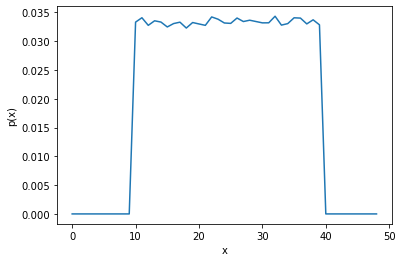

In [3]:
rng = np.random.default_rng()
samples = rng.uniform(low=10, high=40, size=100_000)
distribution_plot(samples, bins=50)

## Exponential distribution

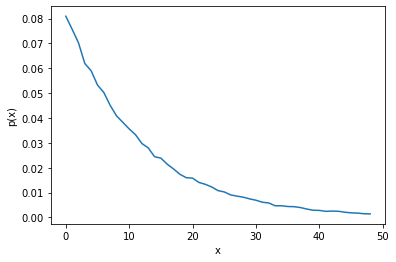

In [4]:
rng = np.random.default_rng()
samples = rng.exponential(scale=12, size=100_000)
distribution_plot(samples, bins=50)

## Normal distribution

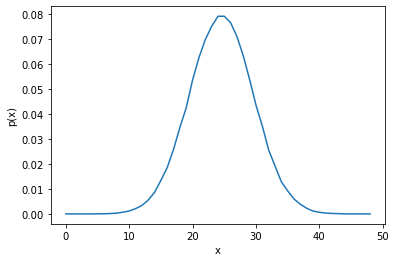

In [5]:
rng = np.random.default_rng()
samples = rng.normal(loc=25.0, scale=5.0, size=100_000)
distribution_plot(samples, bins=50)

## Controlling sampling in simulations

A Professor of Computer Simulation once told me '*remember that a stochastic simulation is not a random game against nature - you are in control*'.  This has always stuck with me.  What the famous Prof was referring to is that in a simulation we can control the streams of psuedo random numbers and hence make our results repeatable. 

> In case you are wondering **stochastic** here refers to a model that is probabilistic.  This means that a single run of a model does not provide an accurate picture of model performance/behaviour.  You need to run the model multiple times to generate a distribution.

The best way to explain the idea of streams and repeatability is by demonstrating with a simple model.  We'll first need to properly introduce a `numpy.random.Generator` that I used above.

```{admonition} tip
:class: tip
`numpy` also provides `numpy.random.RandomState` objects for sampling.  `RandomState` is a legacy implementation included for backwards compatibility with older code.  For new and updated code bases you should make use of `numpy.random.Generator`.  You might also encountered code that samples directly from `random` for example `np.random.randint(...)`.  This is still using a RandomState object and should be avoided for newer code.  Lot's of code on the web will make use of `RandomState`.  If you implement it update it! 
```

To create a `Generator` use the `default_rng()` function

In [6]:
rng = np.random.default_rng()

Consider a project where you are modelling a simple two stage patient pathway. 

* In the first stage of the pathway patients undergo a procedure that requires on average a 3 day spell in hospital. 
* In the second stage the patient undergoes therapy at home.  On average a patient requires home therapy for 7 days.  
* A hospital is interested in what would happen to resource requirements if an intervention they have planned reduced demand on the service. 

Let's test out a simple model where we sample patients length of stay and home therapy durations.  We will model the length of stay variables as exponential distribution.

The first problem will encounter is repeatability.

In [7]:
import pandas as pd

In [8]:
def print_patient_details(acute, home):
    '''
    Helper function.
    Formats length of stay in data frame
    '''
    #pd.set_option('precision', 2)
    #df = pd.DataFrame(np.vstack([sample_acute, sample_home])).T
    #df.columns = ['acute', 'home']
    results = np.vstack([acute, home]).T.round(2)
    print('patient\tacute\thome\n--------------------')
    for i in range(len(results)):
        print(f'{i}\t{results[i][0]}\t{results[i][1]} ')

In [9]:
N_PATIENTS = 5

#create two random generator objects
rng = np.random.default_rng()

# scale parameter = mean
sample_acute = rng.exponential(scale=3, size=N_PATIENTS)
sample_home = rng.exponential(scale=7, size=N_PATIENTS)

# display patient details
print_patient_details(sample_acute, sample_home)

patient	acute	home
--------------------
0	2.05	1.0 
1	0.79	9.44 
2	4.09	4.66 
3	5.0	2.18 
4	2.12	1.75 


### Problem 1: repeatability

The first problem we encounter is repeatability. Each time you run the code above you will get a different result.  For any scientific study we produce or publish we want the results to be repeatable.  On a practical level the lack of repeatability makes debugging, testing and fixing code very difficult. We can solve this problem using a random seed.  This is just a parameter you pass to `default_rng`.  Try running the code below multiple times you shoud get the same results each run.

In [10]:
N_PATIENTS = 5
SEED = 42

#create two random generator objects
rng = np.random.default_rng(SEED)

# scale parameter = mean
sample_acute = rng.exponential(scale=3, size=N_PATIENTS)
sample_home = rng.exponential(scale=7, size=N_PATIENTS)

# display patient details
print_patient_details(sample_acute, sample_home)

patient	acute	home
--------------------
0	7.21	10.17 
1	7.01	9.87 
2	7.15	21.87 
3	0.84	0.56 
4	0.26	7.33 


## Problem 2: streams

Streaming psuedo random numbers presents itself in a much more subtle manner.  To see its effect we will test out the simple model. We will use a random number seed and run two scenarios.  In the first scenario we will test sample 5 patients.  In the second we will sample 2.

In [11]:
def scenario(n_patients, seed=None):
    rng = np.random.default_rng(seed)
    sample_acute = rng.exponential(scale=3, size=n_patients)
    sample_home = rng.exponential(scale=7, size=n_patients)
    print_patient_details(sample_acute, sample_home)

In [12]:
scenario(n_patients=5, seed=42)

patient	acute	home
--------------------
0	7.21	10.17 
1	7.01	9.87 
2	7.15	21.87 
3	0.84	0.56 
4	0.26	7.33 


In [13]:
scenario(n_patients=2, seed=42)

patient	acute	home
--------------------
0	7.21	16.69 
1	7.01	1.96 


When the number of patients is reduced from 5 to 2 we get different sample values for the home therapy durations.  This is problematic because if we are not careful we may attribute improvements or lack of improvements between designs simply due to sampling variation.  We may also induce a correlation between the two random variables.

We get this result because both distributions are using the same single stream of pseudo random numbers.  One way to solve this problem is therefore to give each distribution its **own stream**.

In [14]:
def updated_scenario(n_patients, seeds=(42, 101)):
    rng_acute = np.random.default_rng(seeds[0])
    rng_home = np.random.default_rng(seeds[1])
    sample_acute = rng_acute.exponential(scale=3, size=n_patients)
    sample_home = rng_home.exponential(scale=7, size=n_patients)
    print_patient_details(sample_acute, sample_home)

In [15]:
updated_scenario(n_patients=5)

patient	acute	home
--------------------
0	7.21	28.63 
1	7.01	4.05 
2	7.15	6.69 
3	0.84	7.23 
4	0.26	4.48 


In [16]:
updated_scenario(n_patients=2)

patient	acute	home
--------------------
0	7.21	28.63 
1	7.01	4.05 
